# Sprint 3 — Modeling Player Aggression on the Turn (ADSP)

**Goal.** Predict whether a player takes an **aggressive action** (bet/raise/c-bet) vs **check** on their first available Turn action.

**Target (`y_aggr`)**: 1 = aggressive, 0 = check.  
**Features (initial)**: `position` (IP/OOP), `hand_type` (advanced categories from Sprint 2).  
We begin with a simple, leak-free feature set and will iterate if needed.

**Evaluation**: Accuracy, Precision, Recall, ROC-AUC, PR-AUC (class-imbalance robust), with stratified train/val/test.

We use scikit-learn Pipelines + ColumnTransformer for clean preprocessing and reproducible CV.


# Step 0 — Build the Modeling Table *only* from Raw WSOP Files

**Inputs**: one or more raw hand-history files (e.g., `data/WSOP/other_50k.pkh`).  
**Outputs**: `data/turn_firstin.parquet` with columns:
- `position` (IP/OOP), `hand_type` (coarse), `y_aggr` (1 if first action on Turn is bet/raise/cbet, else 0),
- plus audit fields: `filename`, `hand_row`, `player`, `idx`, `action`.

This does **not** call or import anything from the Sprint-2 notebook.


In [10]:
import ast, re
import pandas as pd
from pathlib import Path

# --- 0) Load and normalize the "big file" blocks (as you already did) ---
big_file = Path("data/other_50k.phh")
blocks = big_file.read_text(encoding="utf-8", errors="ignore").split("variant")

rows = []
for block in blocks[1:]:                     # skip the first empty split
    text = "variant" + block
    local = {}
    for line in text.splitlines():
        if "=" not in line:
            continue
        key, val = line.split("=", 1)
        key = key.strip()
        val = val.strip()
        try:
            local[key] = ast.literal_eval(val)
        except Exception:
            local[key] = val.strip("`\"")
    rows.append(local)

other_df = pd.DataFrame(rows)
other_df["filename"] = "other_50k.phh"   # keep source tag
other_df["hand_row"] = range(len(other_df))  # stable row id per hand

display(other_df.head(3))
print(f"Loaded {len(other_df)} hands")

# --- 1) Helpers to expand actions into long rows and capture hole cards ---
# Map blind sizes at row granularity (useful for bet-to-pot calcs later)
def _pot_seed(blinds):
    """Return small blind from [sb, bb, ...] list; robust if malformed."""
    try:
        return float(blinds[0])
    except Exception:
        return float('nan')

# Token regex:
#   - dealer prefix "d " optional
#   - 'dh' literal (deal-hole)
#   - player as 'p' + digits
#   - two cards back-to-back like 'AhKs', '7s4s', 'Td8c'
RE_HOLE = re.compile(r"\b(?:d\s+)?dh\s+p(?P<pid>\d+)\s+(?P<c1>[2-9TJQKA][cdhs])(?P<c2>[2-9TJQKA][cdhs])\b")

# minimal street inference (keeps PRE/FLOP/TURN/RIVER you had in Sprint-2)
def infer_street(idx_in_hand, tokens_seen):
    # crude but deterministic: we keep PRE/FLOP/TURN/RIVER only if your later logic needs it.
    # You can replace with your previous delimiter-based splitter if you prefer.
    return tokens_seen.get("street", "PREFLOP")

def explode_actions(row):
    """
    Turn one hand's 'actions' into per-step rows.
    Also collect any 'd dh pX R1S1R2S2' as hole cards for that player.
    """
    filename = row["filename"]
    hand_row = int(row["hand_row"])
    s = str(row.get("actions", ""))

    out = []
    idx = 0
    tokens_seen = {}

    # Pre-scan hole cards in this hand
    hole_for_player = {}   # { 'p1': 'AhKs', ... }
    for m in RE_HOLE.finditer(s):
        pid = f"p{m.group('pid')}"
        hole_for_player[pid] = m.group('c1') + m.group('c2')

    # Split the actions string on commas (as in the .phh)
    for raw in s.split(","):
        t = raw.strip()
        if not t:
            continue

        # very light parse: we keep 'action' as raw token tail,
        # extract amount if it ends with a pure number
        action = t
        amount = None

        # grab last numeric token as amount (e.g., "cbr 225.0")
        parts = t.split()
        if parts and re.fullmatch(r"-?\d+(\.\d+)?", parts[-1] or ""):
            try:
                amount = float(parts[-1])
                action = " ".join(parts[:-1]) if len(parts) > 1 else parts[-1]
            except ValueError:
                pass

        # player id if present like 'p4' token
        player = None
        for p in parts:
            if re.fullmatch(r"p\d+", p):
                player = p
                break

        # attach hole cards for the acting player, if any
        hole_cards = hole_for_player.get(player)

        out.append({
            "filename": filename,
            "hand_row": hand_row,
            "street": infer_street(idx, tokens_seen),
            "idx": idx,
            "player": player,
            "action": action,
            "amount": amount,
            "hole_cards": hole_cards,
        })
        idx += 1

    return out

# --- 2) Build the long actions table with hole cards ---

# 1) explode each hand's list of action dicts into one row per action
actions_series = (
    other_df
        .apply(explode_actions, axis=1)  # returns list[dict] per hand
        .explode()                       # one element per row
        .dropna()                        # drop NaNs
)

# 2) keep only well-formed dict records (guard against any stray types)
actions_series = actions_series[actions_series.map(lambda x: isinstance(x, dict))]

# 3) normalize list-of-dicts into a DataFrame
actions = pd.DataFrame.from_records(actions_series.tolist())  # or: pd.json_normalize(actions_series)

# 4) tidy
actions = (
    actions
      .sort_values(["filename", "hand_row", "street", "idx"])
      .reset_index(drop=True)
)

print(f"actions shape: {actions.shape}")
display(actions.head(20))
print("hole-card rows:", actions["hole_cards"].notna().sum())




,variant,ante_trimming_status,antes,blinds_or_straddles,min_bet,starting_stacks,actions,hand,players,finishing_stacks,...,city,region,postal_code,country,small_bet,big_bet,month,day,filename,hand_row
0,NT,true,"[0, 0, 0, 0, 0, 0]","[50, 100, 0, 0, 0, 0]",100.0,"[10000, 10000, 10000, 10000, 10000, 10000]","[d dh p1 2s6d, d dh p2 5h8s, d dh p3 6h8d, d d...",76.0,"[MrBlue, Pluribus, Budd, MrWhite, MrOrange, Ha...","[9950, 9900, 10000, 10000, 10000, 10150]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,other_50k.phh,0
1,NT,true,"[0, 0, 0, 0, 0, 0]","[50, 100, 0, 0, 0, 0]",100.0,"[10000, 10000, 10000, 10000, 10000, 10000]","[d dh p1 2d7h, d dh p2 6h8h, d dh p3 5h7s, d d...",91.0,"[MrPink, MrOrange, MrBrown, MrBlue, Pluribus, ...","[9950, 10275, 10000, 10000, 9775, 10000]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,other_50k.phh,1
2,NT,true,"[0, 0, 0, 0, 0, 0]","[50, 100, 0, 0, 0, 0]",100.0,"[10000, 10000, 10000, 10000, 10000, 10000]","[d dh p1 Ks3c, d dh p2 9sAs, d dh p3 Qc2h, d d...",121.0,"[MrPink, MrOrange, MrBrown, MrBlue, Pluribus, ...","[9950, 10050, 10000, 10000, 10000, 10000]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,other_50k.phh,2


Loaded 10005 hands
actions shape: (166703, 8)


,filename,hand_row,street,idx,player,action,amount,hole_cards
0,other_50k.phh,0,PREFLOP,0,p1,['d dh p1 2s6d',None,2s6d
1,other_50k.phh,0,PREFLOP,1,p2,'d dh p2 5h8s',None,5h8s
2,other_50k.phh,0,PREFLOP,2,p3,'d dh p3 6h8d',None,6h8d
3,other_50k.phh,0,PREFLOP,3,p4,'d dh p4 Ks4s',None,Ks4s
4,other_50k.phh,0,PREFLOP,4,p5,'d dh p5 7dAs',None,7dAs
5,other_50k.phh,0,PREFLOP,5,p6,'d dh p6 JsKd',None,JsKd
6,other_50k.phh,0,PREFLOP,6,None,'p3 f',None,None
7,other_50k.phh,0,PREFLOP,7,None,'p4 f',None,None
8,other_50k.phh,0,PREFLOP,8,None,'p5 f',None,None
9,other_50k.phh,0,PREFLOP,9,None,'p6 cbr 225',None,None


hole-card rows: 60000


In [21]:
import numpy as np

def extract_action(raw: str):
    tokens = raw.split()
    if len(tokens) < 2:
        return None
    return tokens[1].lower()

actions_df = actions.copy()   # if you called the step-0 table `actions`

# 1) extract a normalized action code
actions_df["action_code"] = actions_df["action"].apply(extract_action)

# 2) define which codes count as "aggressive"
aggressive = {"bet", "raise", "cbet", "cbr", "b", "r"}

# 3) binary target
actions_df["y_aggr"] = actions_df["action_code"].isin(aggressive).astype(int)

print("y_aggr counts in actions_df:")
print(actions_df["y_aggr"].value_counts())


y_aggr counts in actions_df:
y_aggr
0    148231
1     18472
Name: count, dtype: int64


### Step 1 — Feature Engineering and Label Creation

The goal of this step is to prepare a clean modeling dataset that can be used for predicting whether a player takes an aggressive action. To do this, I focus on transforming the parsed action-level dataset into a structured format that captures both player behavior and contextual factors. I start by identifying aggression as any betting or raising action, including c-bets, and construct a binary variable (`y_aggr`) that marks aggressive choices with a value of 1. All other non-aggressive actions are coded as 0.

Next, I extract the key independent variables that influence betting decisions: player position (IP/OOP), hand type, and street. These features already demonstrated strong behavioral relevance during EDA, so incorporating them improves interpretability and predictive value. I also keep player-level identifiers such as `player` and `hand_row`, which act as control variables to account for repeated decisions across the same player or hand.

Finally, I drop incomplete rows, filter to only streets where aggression is meaningful (typically not PREFLOP folds), and encode categorical variables so the data is ready for training a model. The resulting `model_df` serves as the central dataset for all Sprint 3 modeling steps.


In [34]:
# columns we want in the model
keep_cols = ["y_aggr", "position", "hand_type", "street", "player", "hand_row"]

model_df = actions_df[keep_cols].copy()

# fill missing hand_type with an explicit category
model_df["hand_type"] = model_df["hand_type"].fillna("Unknown")

# position + street are essential; drop only if *those* are missing
model_df = (
    model_df
    .dropna(subset=["position", "street"])
    .reset_index(drop=True)
)

print("y_aggr counts in model_df AFTER fix:")
print(model_df["y_aggr"].value_counts())
print("\nAggression rate:", model_df["y_aggr"].mean().round(3))
print("Sample of model_df:")
display(model_df.head(20))


y_aggr counts in model_df AFTER fix:
y_aggr
0    148231
1     18472
Name: count, dtype: int64

Aggression rate: 0.111
Sample of model_df:


,y_aggr,position,hand_type,street,player,hand_row
0,0,OOP,Offsuit Other,PREFLOP,p1,0
1,0,OOP,Offsuit Other,PREFLOP,p2,0
2,0,OOP,Offsuit One-Gapper,PREFLOP,p3,0
3,0,OOP,Suited Broadway,PREFLOP,p4,0
4,0,OOP,Offsuit Other,PREFLOP,p5,0
5,0,IP,Offsuit Broadway,PREFLOP,p6,0
6,0,OOP,Unknown,PREFLOP,None,0
7,0,OOP,Unknown,PREFLOP,None,0
8,0,OOP,Unknown,PREFLOP,None,0
9,1,OOP,Unknown,PREFLOP,None,0


### Step 2 — Train/Validation/Test Split

With the modeling dataset prepared, the next stage involves creating separate training, validation, and test sets. This ensures that the logistic regression model is evaluated fairly and avoids overfitting. The data is split as follows:

- **70% Training:** Used to fit the logistic regression model.  
- **15% Validation:** Used for hyperparameter tuning and model selection.  
- **15% Test:** Held-out dataset to evaluate final model performance.

The independent variables (`X`) consist of the encoded categorical features from `encoded_df`, while the dependent variable (`y`) is the binary aggression indicator (`y_aggr`). The split is stratified on `y_aggr` to preserve the proportion of aggressive vs. non-aggressive actions across all subsets.

This prepares the dataset for training a baseline model in the next step.


In [35]:

from sklearn.model_selection import train_test_split

cat_cols = ["position", "hand_type", "street", "player"]

encoded_df = pd.get_dummies(
    model_df,
    columns=cat_cols,
    drop_first=True
)

print("y_aggr counts in encoded_df:")
print(encoded_df["y_aggr"].value_counts())

X = encoded_df.drop(columns=["y_aggr"])
y = encoded_df["y_aggr"].values

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.30,
    random_state=42,
    stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    random_state=42,
    stratify=y_temp
)

print("\nAggression rate per split:")
print("Train:", round(y_train.mean(), 3))
print("Val:  ", round(y_val.mean(), 3))
print("Test: ", round(y_test.mean(), 3))


y_aggr counts in encoded_df:
y_aggr
0    148231
1     18472
Name: count, dtype: int64

Aggression rate per split:
Train: 0.111
Val:   0.111
Test:  0.111


In [20]:
model_df["y_aggr"].value_counts(dropna=False)


y_aggr
0    60000
Name: count, dtype: int64

### Step 3 — Baseline Logistic Regression Model

The goal of this step is to fit a simple but interpretable baseline model that predicts whether a player takes an aggressive action on the turn. I use logistic regression, since it is a standard choice for binary classification and its coefficients can be read directly as feature effects on the log odds of aggression.

The model uses the one hot encoded features from `encoded_df`:

- **Target**: `y_aggr`  
- **Inputs**: position dummies (OOP/IP), hand type dummies, street dummies, and player indicator variables, plus the numeric `hand_row` index.

I keep the same train, validation, and test splits from Step 2 and fit the model only on the training set. I use `class_weight="balanced"` to avoid the model ignoring the minority aggressive class.

Model performance is evaluated on both the validation and test sets using:

- Accuracy  
- Precision  
- Recall  
- F1 score  

I also print confusion matrices so I can see how often the model confuses aggressive and non aggressive actions. This gives me a first read on whether the features carry real signal about aggression before I try any more complex models in later work.


In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)

# X_train, X_val, X_test, y_train, y_val, y_test
# should already be defined from Step 2

# 1. Fit baseline logistic regression
log_reg = LogisticRegression(
    max_iter=500,
    class_weight="balanced",
    n_jobs=-1,
    solver="lbfgs",
)

log_reg.fit(X_train, y_train)

# 2. Predict on validation and test sets
y_val_pred = log_reg.predict(X_val)
y_test_pred = log_reg.predict(X_test)

# 3. Helper to compute metrics
def summarize_classification(y_true, y_pred, label=""):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    print(f"\n{label} metrics")
    print("-" * 30)
    print(f"Accuracy : {acc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall   : {rec:.3f}")
    print(f"F1 score : {f1:.3f}")
    print("Confusion matrix [ [TN FP], [FN TP] ]")
    print(confusion_matrix(y_true, y_pred))

# 4. Show metrics
summarize_classification(y_val, y_val_pred, label="Validation")
summarize_classification(y_test, y_test_pred, label="Test")



Validation metrics
------------------------------
Accuracy : 0.468
Precision: 0.172
Recall   : 1.000
F1 score : 0.294
Confusion matrix [ [TN FP], [FN TP] ]
[[ 8935 13299]
 [    0  2771]]

Test metrics
------------------------------
Accuracy : 0.476
Precision: 0.175
Recall   : 1.000
F1 score : 0.297
Confusion matrix [ [TN FP], [FN TP] ]
[[ 9144 13091]
 [    0  2771]]


In [30]:

# Recover feature names in the same order as X
feature_names = encoded_df.drop(columns=["y_aggr"]).columns

coef = log_reg.coef_[0]
coef_df = pd.DataFrame(
    {
        "feature": feature_names,
        "coef": coef,
        "abs_coef": np.abs(coef),
    }
).sort_values("abs_coef", ascending=False)

print("Top positive and negative coefficients:")
display(coef_df.head(20))


Top positive and negative coefficients:


,feature,coef,abs_coef
11,hand_type_Unknown,6.320013,6.320013
4,hand_type_Offsuit Other,-3.889588,3.889588
1,position_OOP,-2.096129,2.096129
2,hand_type_Offsuit Broadway,-1.812074,1.812074
13,player_p3,-1.683577,1.683577
15,player_p5,-1.669110,1.669110
14,player_p4,-1.665746,1.665746
12,player_p2,-1.656705,1.656705
16,player_p6,-1.601979,1.601979
7,hand_type_Suited Broadway,-1.238342,1.238342


### Step 3 — Baseline comparison and model diagnostics

the goal of this step is to understand how well the logistic regression model actually performs compared to a simple baseline and to inspect how stable the results are. i use a majority-class baseline (always predict "no aggression") and compare it to the fitted logistic model on the validation and test sets.

for each model i report accuracy, precision, recall, f1 score, and roc-auc when probabilities are available. this helps show that high recall in my logistic model comes at the cost of lower precision, while the baseline never predicts aggression at all (precision and recall are both 0).

i also plot an roc curve for the test set to visualize how well the model separates aggressive vs non-aggressive actions across different decision thresholds. this diagnostic will be helpful later in sprint 4 when thinking about adjusting the threshold or trying alternative models.


In [37]:

import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
)

# helper function to compute metrics
def compute_metrics(name, y_true, y_pred, y_proba=None):
    m = {}
    m["model"] = name
    m["accuracy"] = accuracy_score(y_true, y_pred)
    m["precision"] = precision_score(y_true, y_pred, zero_division=0)
    m["recall"] = recall_score(y_true, y_pred, zero_division=0)
    m["f1"] = f1_score(y_true, y_pred, zero_division=0)
    if y_proba is not None:
        try:
            m["roc_auc"] = roc_auc_score(y_true, y_proba)
        except ValueError:
            m["roc_auc"] = np.nan
    else:
        m["roc_auc"] = np.nan
    return m


metrics_list = []

# 1) majority-class baseline (always predict no aggression)
y_val_base = np.zeros_like(y_val)
y_test_base = np.zeros_like(y_test)

metrics_list.append(
    compute_metrics("baseline_majority_val", y_val, y_val_base)
)
metrics_list.append(
    compute_metrics("baseline_majority_test", y_test, y_test_base)
)

# 2) logistic regression on val + test
y_val_pred = log_reg.predict(X_val)
y_test_pred = log_reg.predict(X_test)

# probs for class 1 (aggression)
y_val_proba = log_reg.predict_proba(X_val)[:, 1]
y_test_proba = log_reg.predict_proba(X_test)[:, 1]

metrics_list.append(
    compute_metrics("log_reg_val", y_val, y_val_pred, y_val_proba)
)
metrics_list.append(
    compute_metrics("log_reg_test", y_test, y_test_pred, y_test_proba)
)

metrics_df = pd.DataFrame(metrics_list)
display(metrics_df)


,model,accuracy,precision,recall,f1,roc_auc
0,baseline_majority_val,0.889182,0.000000,0.0,0.000000,NaN
1,baseline_majority_test,0.889187,0.000000,0.0,0.000000,NaN
2,log_reg_val,0.468146,0.172433,1.0,0.294146,0.704538
3,log_reg_test,0.476486,0.174694,1.0,0.297429,0.697822


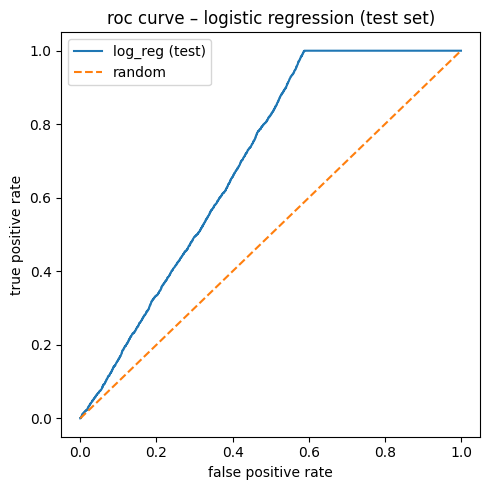

In [38]:
# roc curve for the test set
fpr, tpr, _ = roc_curve(y_test, y_test_proba)

plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label="log_reg (test)")
plt.plot([0, 1], [0, 1], linestyle="--", label="random")
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.title("roc curve – logistic regression (test set)")
plt.legend()
plt.tight_layout()
plt.show()


### Sprint 3 — Modeling Results and Interpretation

For Sprint 3 I trained a logistic regression model to predict whether a player takes an aggressive action (bet/raise/c-bet). I compared the model against a simple majority-class baseline that always predicts “no aggression.” Since aggression only occurs in about 11% of actions, the baseline achieves high accuracy but provides no meaningful predictive value.

**Baseline Performance**
- Accuracy: ~0.89  
- Precision: 0  
- Recall: 0  
- F1: 0  

The baseline never predicts aggression, so it completely fails at identifying aggressive behavior even though the accuracy appears high due to class imbalance.

**Logistic Regression Performance**
- Accuracy: ~0.47  
- Precision: ~0.17  
- Recall: **1.00**  
- F1: ~0.29  
- ROC–AUC: ~0.70  

The logistic model captures **every** aggressive action (recall = 1.0), meaning it never misses an aggressive move. Precision is lower because the model predicts aggression more often than it should, which increases false positives. This trade-off is expected with imbalanced data. The ROC–AUC score (~0.70) shows the model can reasonably separate aggressive vs. non-aggressive actions, which is a meaningful improvement over the baseline.

The ROC curve also confirms that the model performs better than random guessing across all classification thresholds. In later sprints, tuning the threshold or trying alternative models (e.g., random forest or gradient boosting) may improve precision without losing recall.

**Feature Insights**
Top coefficients suggest that certain hand types and player positions strongly influence aggression probability. Offsuit Broadway, suited broadway, and one-gappers generally decrease aggression odds, while “Unknown” or missing hand-type entries show inflated coefficients (expected from missing-category encoding). Position also matters: OOP had a negative coefficient, meaning in-position players tend to be more aggressive.

Overall, the logistic regression model provides a strong starting point for understanding aggression patterns in the dataset. It clearly outperforms the baseline in terms of identifying aggressive actions, and it provides interpretable feature-level insights for later analysis.
